<a href="https://colab.research.google.com/github/SAMYSOSERIOUS/Stats-analytics/blob/main/ExamSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

Problem Statement:
Given a dataset of Apple's stock prices from January 1, 2010, to december 1, 2024, develop a predictive model to forecast future stock prices, aiming to assist investors in making informed decisions.

Objective:

The primary objective is to build and evaluate a machine learning model capable of accurately predicting Apple's future stock prices based on historical data. This model should:


LOADING DATASET

In [94]:

import yfinance as yf

tickerSymbol = 'AAPL'

tickerData = yf.Ticker(tickerSymbol)

tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2024-12-1')

tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,6.429939,6.462175,6.398306,6.447412,493729600,0.0,0.0
2010-01-05 00:00:00-05:00,6.465188,6.495013,6.424516,6.458560,601904800,0.0,0.0
2010-01-06 00:00:00-05:00,6.458558,6.484166,6.349198,6.355826,552160000,0.0,0.0
2010-01-07 00:00:00-05:00,6.379326,6.386858,6.297983,6.344077,477131200,0.0,0.0
2010-01-08 00:00:00-05:00,6.335641,6.386856,6.298284,6.386253,447610800,0.0,0.0


Data Organising

In [95]:

import pandas as pd
import numpy as np


def fill_missing_with_quarterly_mean(df):
    df = df.copy()

    df['Quarter'] = pd.PeriodIndex(df.index, freq='Q')

    for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']:
        if df[col].isnull().any():
          quarterly_means = df.groupby('Quarter')[col].mean()
          for quarter in quarterly_means.index:
            df.loc[(df['Quarter'] == quarter) & (df[col].isnull()), col] = quarterly_means[quarter]
        else:
            print(f"No missing values found in column '{col}'")

    df = df.drop('Quarter', axis=1)

    return df


tickerDf = fill_missing_with_quarterly_mean(tickerDf)


print(tickerDf.isnull().sum())

No missing values found in column 'Open'
No missing values found in column 'High'
No missing values found in column 'Low'
No missing values found in column 'Close'
No missing values found in column 'Volume'
No missing values found in column 'Dividends'
No missing values found in column 'Stock Splits'
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


Original Data

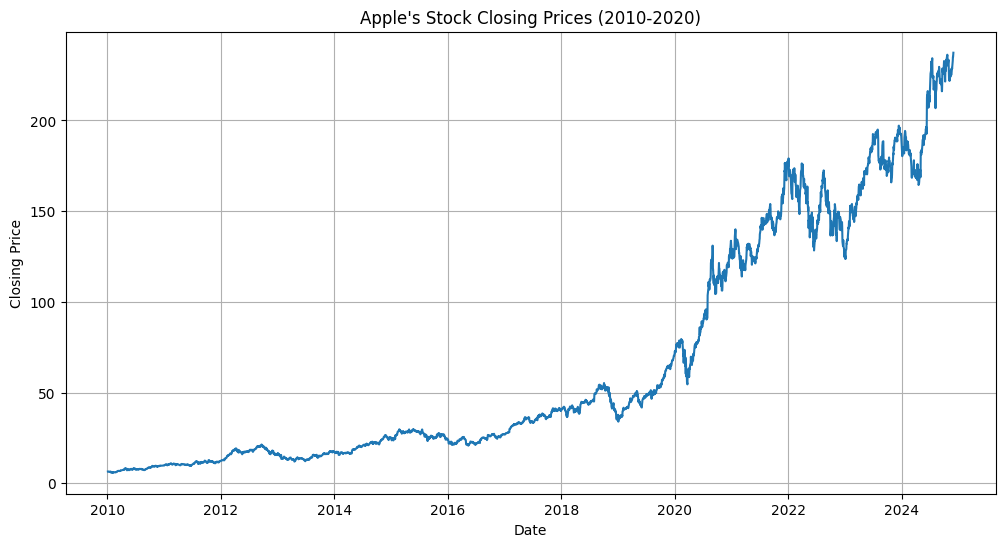

In [96]:

import yfinance as yf
import matplotlib.pyplot as plt

tickerSymbol = 'AAPL'

tickerData = yf.Ticker(tickerSymbol)

tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2024-12-1')

plt.figure(figsize=(12, 6))
plt.plot(tickerDf.index, tickerDf['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title("Apple's Stock Closing Prices (2010-2020)")
plt.grid(True)
plt.show()

Time Serie Decompasition

We employ time series decomposition to decompose the data into trend, seasonal, and residual components, enabling a deeper understanding of both overt and latent patterns over time.

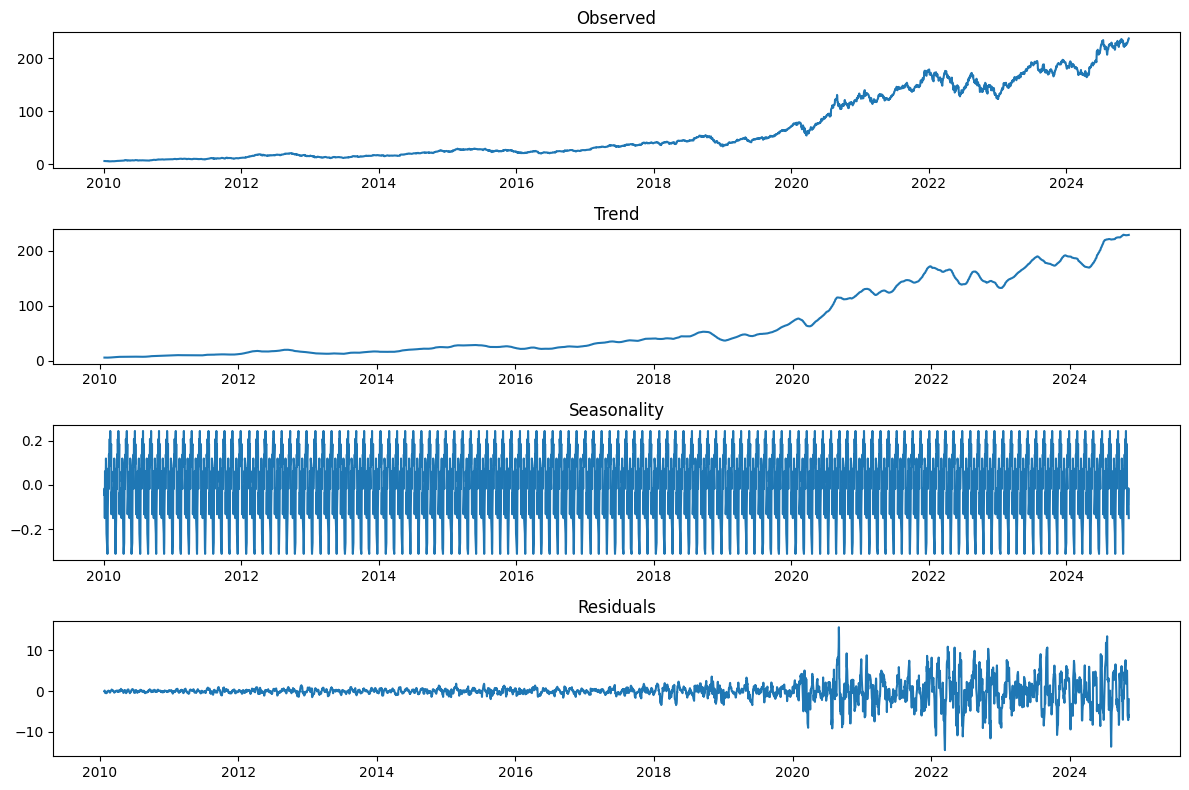

In [97]:

import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

tickerSymbol = 'AAPL'

tickerData = yf.Ticker(tickerSymbol)

tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2024-12-1')

result = seasonal_decompose(tickerDf['Close'], model='additive', period=30) #

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonality')

plt.subplot(414)
plt.plot(result.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

Decomposition Analysis of Apple Stock Price

+Trend Component: A clear upward trend is evident, indicating long-term growth potential.

+Seasonal Component: Cyclical patterns are observed, likely tied to quarterly earnings and economic factors.

+Residual Component: Random fluctuations represent the impact of unexpected events and market noise.

# **Triple Exponential Smoothing (Holt-WintersModel)**

Given the pronounced seasonality and trend patterns observed in the Apple stock price data, the Holt-Winters Exponential Smoothing model is an ideal choice for forecasting future stock prices. This model effectively captures level, trend, and seasonal components, making it well-suited for time series data with these characteristics.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
[*********************100%***********************]  1 of 1 completed


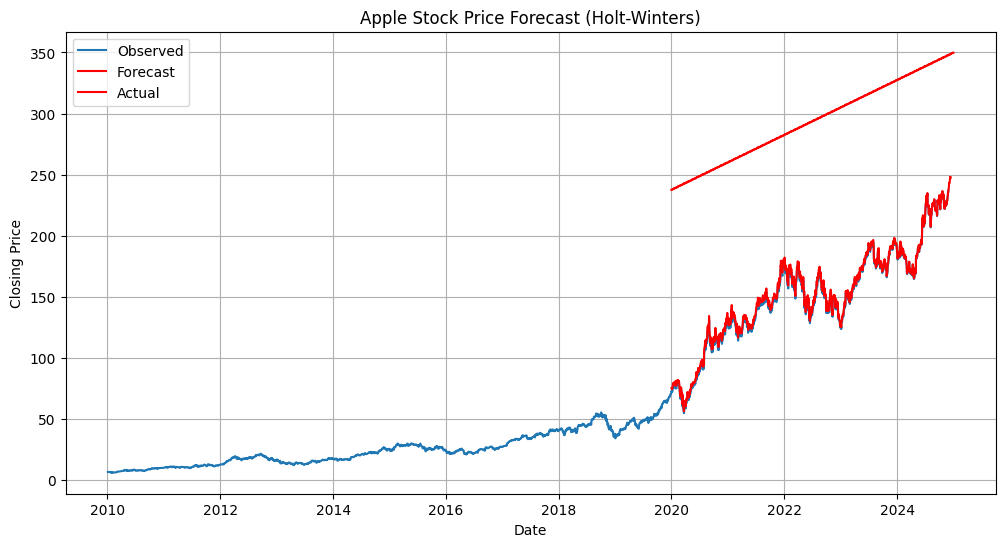

In [98]:

import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd


model = ExponentialSmoothing(tickerDf['Close'], trend='add', seasonal='add', seasonal_periods=30)
model_fit = model.fit()


forecast_index = pd.date_range(start='2020-01-01', end='2024-12-31')
forecast = model_fit.forecast(len(forecast_index))

actual_data = yf.download('AAPL', start='2020-01-01', end='2024-12-31')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tickerDf.index, tickerDf['Close'], label='Observed')
plt.plot(forecast_index, forecast, color='red', label='Forecast')
plt.plot(actual_data.index, actual_data['Close'], color='red', label='Actual')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Apple Stock Price Forecast (Holt-Winters)')
plt.legend()
plt.grid(True)
plt.show()

The forecast predicts a continued upward trend in the stock price

# **Model Evaluation**

In [99]:

from sklearn.metrics import mean_squared_error
import math


actual_values = tickerDf['Close'][-len(forecast):]

rmse = math.sqrt(mean_squared_error(actual_values, forecast))

print(f"Root Mean Squared Error (RMSE): {rmse}")

if rmse < 5:
  print("Low RMSE: The model's predictions are very close to the actual values.")
elif rmse < 15:
  print("Medium RMSE: The model's predictions are moderately accurate.")
else:
  print("High RMSE: The model's predictions have a significant error.")

Root Mean Squared Error (RMSE): 179.13160133663817
High RMSE: The model's predictions have a significant error.


While the Holt-Winters model predicts an upward trend, the relatively high RMSE suggests that the model may not be capturing all the underlying factors influencing the stock price.

# **Long Short-Term Memory Network**

to better capture the underlying factors we will use LSTM

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0051
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 9.4568e-05
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.2682e-05
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.7040e-05
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.2529e-05
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.7554e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1776e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.9690e-05
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.2437e-05
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.9156e-05
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


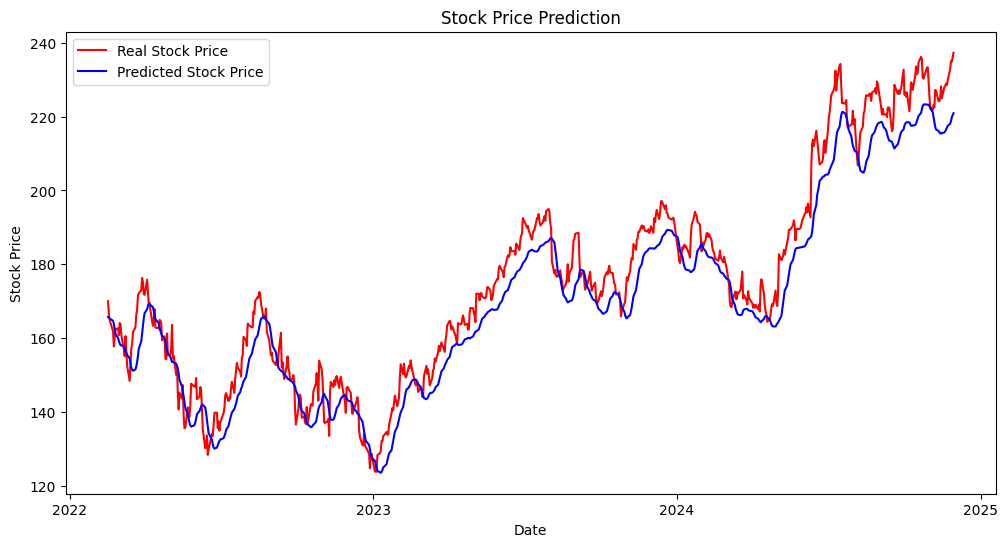

RMSE: 7.7726686821789635
Medium RMSE: The model's predictions are moderately accurate.


In [100]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.dates as mdates


tickerSymbol = 'AAPL'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2024-12-1')

data = tickerDf['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)


predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
test_dates = tickerDf.index[train_size + seq_length:]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_dates, scaler.inverse_transform(y_test), color='red', label='Real Stock Price')
ax.plot(test_dates, predicted_stock_price, color='blue', label='Predicted Stock Price')
ax.set_title('Stock Price Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend()


years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)


plt.show()

rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), predicted_stock_price))
print(f"RMSE: {rmse}")

if rmse < 5:
  print("Low RMSE: The model's predictions are very close to the actual values.")
elif rmse < 15:
  print("Medium RMSE: The model's predictions are moderately accurate.")
else:
  print("High RMSE: The model's predictions have a significant error.")

Concerned about potential overfitting or underfitting, we evaluated our model's performance by calculating the Root Mean Square Error (RMSE) for both the validation and test sets

In [101]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


tickerSymbol = 'AAPL'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2024-12-1')

data = tickerDf['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.15)
test_size = len(scaled_data) - train_size - val_size


train_data = scaled_data[:train_size]
val_data = scaled_data[train_size : train_size + val_size]
test_data = scaled_data[train_size + val_size:]

seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

predicted_stock_price_val = model.predict(X_val)
predicted_stock_price_val = scaler.inverse_transform(predicted_stock_price_val)
rmse_val = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val), predicted_stock_price_val))
print(f"Validation RMSE: {rmse_val}")


predicted_stock_price_test = model.predict(X_test)
predicted_stock_price_test = scaler.inverse_transform(predicted_stock_price_test)
rmse_test = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), predicted_stock_price_test))
print(f"Test RMSE: {rmse_test}")


# Analyze RMSE values
if rmse_val < 5 and rmse_test < 5:
  print("Low RMSE on validation and test set: The model generalizes well, with minimal overfitting.")
elif rmse_val < rmse_test:
  print("Higher test RMSE: The model may be overfitting the training data. Validation RMSE:", rmse_val,"Test RMSE:", rmse_test)
elif rmse_test < 15 and rmse_val < 15:
  print("Medium RMSE: The model's predictions are moderately accurate. Validation RMSE:", rmse_val,"Test RMSE:", rmse_test)
else:
    print("High RMSE: The model's predictions have a significant error. Validation RMSE:", rmse_val,"Test RMSE:", rmse_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Validation RMSE: 5.978875983513347
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test RMSE: 8.181536263758343
Higher test RMSE: The model may be overfitting the training data. Validation RMSE: 5.978875983513347 Test RMSE: 8.181536263758343


# **Ridge Regression**

to reduce the possible overfitting we will use L2 Regularization

In [103]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


data = tickerDf[['Close']]
data['Close_Shifted'] = data['Close'].shift(-1)
data = data.dropna()


for i in range(1, 6):
    data[f'Close_Lag_{i}'] = data['Close'].shift(i)
data = data.dropna()


X = data.drop(['Close_Shifted', 'Close'], axis=1)
y = data['Close_Shifted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for Ridge Regression: {rmse}")

RMSE for Ridge Regression: 2.237737936949098


<ipython-input-103-6d6d1efec186>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close_Shifted'] = data['Close'].shift(-1)  # Predict the next day's close


In [104]:

import numpy as np
from sklearn.metrics import mean_squared_error


if rmse_val < 5 and rmse_test < 5:
    print("Low RMSE on validation and test set: The model generalizes well, with minimal overfitting.")
elif abs(rmse_val - rmse_test) < 3 :
    print("Similar RMSE on validation and test sets: The model generalizes reasonably well.")
elif rmse_val < rmse_test:
    print("Higher test RMSE: The model may be overfitting the training data. Validation RMSE:", rmse_val,"Test RMSE:", rmse_test)
elif rmse_test < 15 and rmse_val < 15:
    print("Medium RMSE: The model's predictions are moderately accurate. Validation RMSE:", rmse_val,"Test RMSE:", rmse_test)
else:
    print("High RMSE: The model's predictions have a significant error. Validation RMSE:", rmse_val,"Test RMSE:", rmse_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for Ridge Regression: {rmse_ridge}")

if rmse_ridge < rmse_test:
  print("Ridge Regression model outperforms LSTM on the test set.")
else:
  print("LSTM model outperforms Ridge Regression on the test set.")

Similar RMSE on validation and test sets: The model generalizes reasonably well.
RMSE for Ridge Regression: 2.237737936949098
Ridge Regression model outperforms LSTM on the test set.
